# Binary classification : Tabular data

# 2nd level. Porto Seguro’s Safe Driver Prediction

- https://kaggle-kr.tistory.com/32
- https://www.kaggle.com/c/porto-seguro-safe-driver-prediction
- https://www.kaggle.com/bertcarremans/data-preparation-exploration
- https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial
- https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction

---

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that <b>predicts the probability that a driver will initiate an auto insurance claim in the next year.</b> While Porto Seguro has used machine learning for the past 20 years, they're looking to Kaggle's machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

---

## Setting

gc
- https://blog.winterjung.dev/2018/02/18/python-gc
- python은 기본적으로 garbage collection과 reference counting을 통해 할당된 메모리를 관리
- gc module은 오로지 순환 참조를 탐지하고 해결하기 위해 존재
- gc module로 cyclic garbage collection을 직접 제어하고, 이를 통해 reference cycles를 해결
- gc 파이썬 공식문서에서도 순환 참조를 만들지 않는다고 확신할 수 있으면 gc.disable()을 통해 garbage collector를 비활성화시켜도 된다고 함

In [1]:
#!pip install lightgbm

In [46]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import time
import gc
import re                        # 정규표현식

from collections import Counter

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import missingno as msno         # 결측치 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=1.0)
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold, SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

colors = ['#8fd9b6', '#ff9999', '#D4AFB9', '#D1CFE2', '#9CADCE', '#7EC4CF', '#52B2CF']

# Part1: Exploratory Data Analysis (EDA)

## 1. Dataset 확인

- Features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc)
- Feature names include the postfix <b>bin</b> to indicate <b>binary</b> features and <b>cat</b> to indicate <b>categorical</b> features
- Features without these designations are either continuous or ordinal
- Values of <b>-1 indicate that the feature was missing</b> from the observation
- The target columns signifies whether or not a claim was filed for that policy holder

In [47]:
train = pd.read_csv('../datasets_for_practice/kaggle/safe_driver/train.csv')
test = pd.read_csv('../datasets_for_practice/kaggle/safe_driver/test.csv')

train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


### train.info()
- With the info() method we see that the data type is integer or float
- No null values are present in the data set
- That's normal because missing values are replaced by -1

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [49]:
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.0000

59 columns' data types

In [50]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [51]:
train.dtypes

id                  int64
target              int64
ps_ind_01           int64
ps_ind_02_cat       int64
ps_ind_03           int64
ps_ind_04_cat       int64
ps_ind_05_cat       int64
ps_ind_06_bin       int64
ps_ind_07_bin       int64
ps_ind_08_bin       int64
ps_ind_09_bin       int64
ps_ind_10_bin       int64
ps_ind_11_bin       int64
ps_ind_12_bin       int64
ps_ind_13_bin       int64
ps_ind_14           int64
ps_ind_15           int64
ps_ind_16_bin       int64
ps_ind_17_bin       int64
ps_ind_18_bin       int64
ps_reg_01         float64
ps_reg_02         float64
ps_reg_03         float64
ps_car_01_cat       int64
ps_car_02_cat       int64
ps_car_03_cat       int64
ps_car_04_cat       int64
ps_car_05_cat       int64
ps_car_06_cat       int64
ps_car_07_cat       int64
ps_car_08_cat       int64
ps_car_09_cat       int64
ps_car_10_cat       int64
ps_car_11_cat       int64
ps_car_11           int64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15   

In [52]:
print(train.shape, test.shape)

(595212, 59) (892816, 58)


### Check if there are duplicate rows

In [53]:
train.drop_duplicates()
train.shape

(595212, 59)

### Check y column

In [54]:
print('Columns in train and not in test dataset: ', set(train.columns) - set(test.columns))

Columns in train and not in test dataset:  {'target'}


## 2. Metadata

To facilitate the data management, we'll store meta-information about the variables in a DataFrame. This will be helpful when we want to select specific variables for analysis, visualization, modeling, etc.

Concretely we will store:
- role: input, ID, target
- level: nominal, interval, ordinal, binary
- keep: True or False
- dtype: int, float, str

In [55]:
data = []

for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
    
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == 'int64':
        level = 'ordinal'
    
    # Initialize 'keep' to True for all variables except for Id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type
    dtype = train[f].dtype
    
    category = None
    if 'ind' in f:
        category = 'individual'
    elif 'reg' in f:
        category = 'registration'
    elif 'car' in f:
        category = 'car'
    elif 'calc' in f:
        category = 'calculated'
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {'varname':f, 'role':role, 'level':level, 'keep':keep, 'dtype':dtype, 'category':category}
    data.append(f_dict)

meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype', 'category'])
meta.set_index('varname', inplace=True)

In [56]:
meta

,role,level,keep,dtype,category
varname,,,,,
id,id,nominal,False,int64,None
target,target,binary,True,int64,None
ps_ind_01,input,ordinal,True,int64,individual
ps_ind_02_cat,input,nominal,True,int64,individual
ps_ind_03,input,ordinal,True,int64,individual
ps_ind_04_cat,input,nominal,True,int64,individual
ps_ind_05_cat,input,nominal,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


### Extract all nominal variables that are not dropped

In [57]:
meta[(meta.level=='nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

- size() : 각 그룹의 개수
- reset_index() : index를 행 번호로 설정 (0, 1, 2 ...)

In [58]:
pd.DataFrame({'count' : meta.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,registration,3


In [59]:
pd.DataFrame({'count' : meta.groupby(['role','level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## 3. Descriptive Statistics

### 3.1 Interval variables

- reg variables : only ps_reg_03 has missing values
- car variables : ps_car_12 and ps_car_15 have missing values again
- calc variables : no missing values, all three 'calc' variables have very similar distributions

Overall, we can see that the range of the interval variables is rather small. Perhaps some transformation (e.g. log) is already applied in order to anonymize the data?

In [60]:
v = meta[(meta.level=='interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


### 3.2 Ordinal variables

- Only one missing variable: ps_car_11
- We could apply scaling to deal with the different ranges

In [61]:
v = meta[(meta.level=='ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


### 3.3 Binary variables

- A priori in the train data is 3.645%, which is strongly imbalanced
- From the means we can conclude that for most variables the value is zero in most cases

In [62]:
v = meta[(meta.level=='binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Handling Imbalanced Classes

Target distribution

In [63]:
data = [go.Bar(
    x = train['target'].value_counts().index.values,
    y = train['target'].value_counts().values,
    text = 'Distribution of target variable'
)]

layout = go.Layout(title = 'Target variable distribution', width=500, height=500)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

- oversampling records with target=1
- undersampling records with target=0

In [64]:
desired_apriori = 0.10

# Get the indices per target value
idx_0 = train[train.target==0].index
idx_1 = train[train.target==1].index

# Get original number of records per target value
cnt_0 = len(train.loc[idx_0])
cnt_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting the number of records with target=0
undersampling_rate = ((1 - desired_apriori) * cnt_1) / (desired_apriori * cnt_0)
undersampled_cnt_0 = int(undersampling_rate * cnt_0)
print("Rate to undersample records with 'target=0' : {:.2f}%".format(undersampling_rate*100))
print("Number of records with 'target=0' before undersampling : {}".format(cnt_0))
print("Number of records with 'target=0' after undersampling : {}".format(undersampled_cnt_0))

# Randomly select records with 'target=0' to get at the desired a priori
undersampled_idx_0 = shuffle(idx_0, random_state=42, n_samples=undersampled_cnt_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx_0) + list(idx_1)

# Return undersample data frame
# drop=True : index 열 삭제
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with 'target=0' : 34.04%
Number of records with 'target=0' before undersampling : 573518
Number of records with 'target=0' after undersampling : 195246


In [65]:
train['target'].mean()

0.1

## 5. Data Quality Checks

### 5.1 Check Null or missing values

Missings are represented as -1

In [66]:
train.isnull().any().any()

False

In [67]:
vars_with_missing = []

for f in train.columns:
    missing = train[train[f] == -1][f].count()
    if missing > 0:
        vars_with_missing.append(f)
        missing_pct = missing/train.shape[0]
        print("Variable {:<15} has {:<8} records ({:.2%}) with missing values".format(f, missing, missing_pct))

print('\nIn total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat   has 100      records (0.05%) with missing values
Variable ps_ind_04_cat   has 50       records (0.02%) with missing values
Variable ps_ind_05_cat   has 2317     records (1.07%) with missing values
Variable ps_reg_03       has 38780    records (17.88%) with missing values
Variable ps_car_01_cat   has 57       records (0.03%) with missing values
Variable ps_car_02_cat   has 1        records (0.00%) with missing values
Variable ps_car_03_cat   has 148997   records (68.68%) with missing values
Variable ps_car_05_cat   has 96192    records (44.34%) with missing values
Variable ps_car_07_cat   has 4495     records (2.07%) with missing values
Variable ps_car_09_cat   has 234      records (0.11%) with missing values
Variable ps_car_11       has 1        records (0.00%) with missing values
Variable ps_car_14       has 15534    records (7.16%) with missing values

In total, there are 12 variables with missing values


### 5.2 Visualize missing values

- change '-1' to NaN

In [68]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

replacement of -1 for the nulls might not be a very good strategy.

<AxesSubplot:>

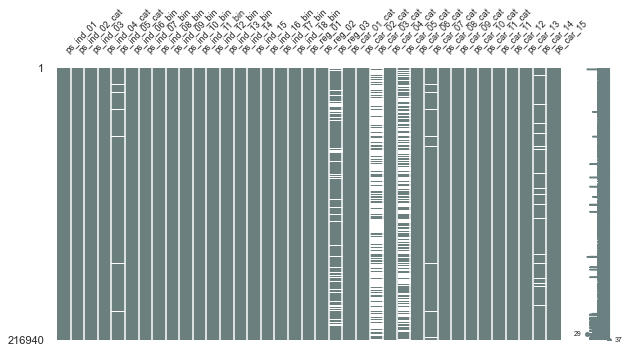

In [69]:
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(10,5), color=(0.42, 0.5, 0.5), fontsize=9)

- We will leave missing value -1 for the <b>categorical</b> variables

### 5.3 Dropping the variables with too many missing values

In [70]:
train.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis=1, inplace=True)
test.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis=1, inplace=True)

meta.loc[(['ps_car_03_cat', 'ps_car_05_cat']), 'keep'] = False

In [71]:
print(train.shape, test.shape)

(216940, 57) (892816, 56)


### 5.4 Imputing with the mean or mode

- ps_reg_03, ps_car_12, ps_car_14 (continuous) -> replace by the mean
- ps_car_11 (ordinal) -> replace by the mode

SimpleImputer
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

In [72]:
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')

cols = ['ps_reg_03', 'ps_car_12', 'ps_car_14']
for col in cols:
    train[col] = mean_imp.fit_transform(train[[col]]).ravel()
    test[col] = mean_imp.fit_transform(test[[col]]).ravel()

train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()
test['ps_car_11'] = mode_imp.fit_transform(test[['ps_car_11']]).ravel()

## 6. Check the cardinality of the categorical variables

<b>Cardinality refers to the number of different values in a variable</b>

As we will create dummy variables from the categorical variables later on, we need to check whether there are variables with many distinct values. We should handle these variables differently as they would result in many dummy variables.

- Only ps_car_11_cat has many distinct values

In [73]:
v = meta[(meta.level=='nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))    

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


Script by https://www.kaggle.com/ogrellier</br>
Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

- trn_series : training categorical feature as a pd.Series
- tst_series : test categorical feature as a pd.Series
- target : target data as a pd.Series
- min_samples_leaf (int) : minimum samples to take category average into account
- smoothing (int) : smoothing effect to balance categorical average vs prior
</br></br>
- assert : 뒤의 조건이 True가 아니면 AssertError 발생
- agg : an alias for aggregate

In [74]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, tst_series=None, target=None,
                  min_samples_leaf=1, smoothing=1, noise_level=0):
    
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    
    temp = pd.concat([trn_series, target], axis=1)
    averages = temp.groupby(by=trn_series.name)[target.name].agg(['mean', 'count'])
    smoothing = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))
    
    prior = target.mean()
    averages[target.name] = prior * (1 - smoothing) + averages['mean'] * smoothing
    averages.drop(['mean', 'count'], axis=1, inplace=True)
    
    ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name),
                             averages.reset_index().rename(columns={'index':target.name, target.name:'average'}),
                             on=trn_series.name, how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    ft_trn_series.index = trn_series.index
    
    ft_tst_series = pd.merge(tst_series.to_frame(tst_series.name),
                             averages.reset_index().rename(columns={'index':target.name, target.name:'average'}),
                             on=tst_series.name, how='left')['average'].rename(tst_series.name + '_mean').fillna(prior)
    
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [75]:
train_encoded, test_encoded = target_encode(train['ps_car_11_cat'], test['ps_car_11_cat'], target=train.target,
                                            min_samples_leaf=100, smoothing=10, noise_level=0.01)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat', 'keep'] = False

test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

In [76]:
print(train.shape, test.shape)

(216940, 57) (892816, 56)


## 7. Visualization

### 7.1 Categorical variables

The customers <b>with a missing value appear to have a much higher (in some cases much lower) probability</b> to ask for an insurance claim.

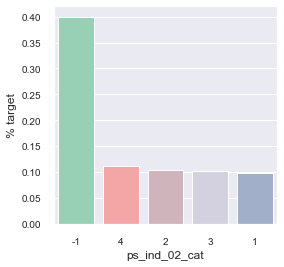

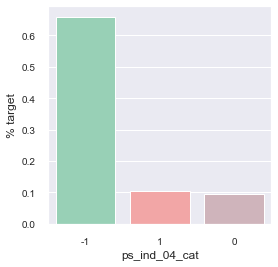

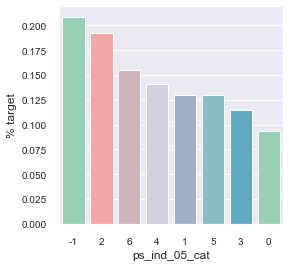

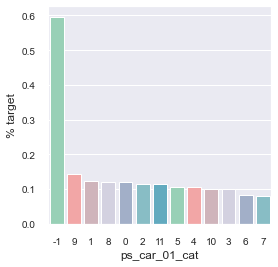

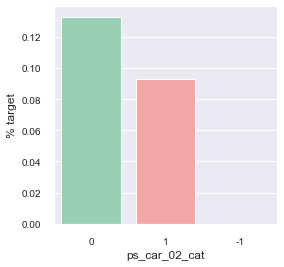

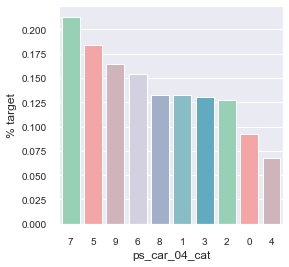

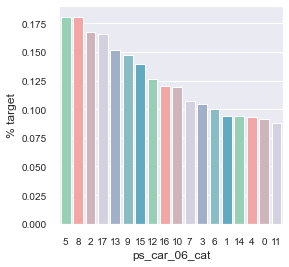

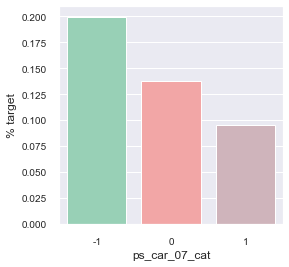

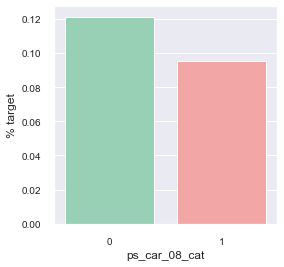

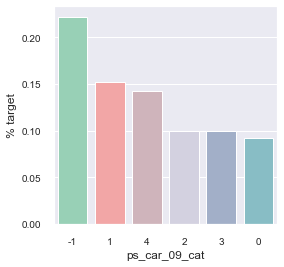

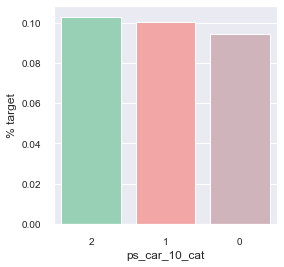

In [77]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    fig, ax = plt.subplots(figsize=(4, 4))
    cat_pct = train[[f, 'target']].groupby([f], as_index=False).mean()
    cat_pct.sort_values(by='target', ascending=False, inplace=True)
    sns.barplot(f, 'target', data=cat_pct, order=cat_pct[f], ax=ax, palette = colors)
    plt.ylabel('% target', fontsize=12)
    plt.xlabel(f, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=10)    
    plt.show()
    

In [78]:
train[['ps_ind_02_cat', 'target']].groupby(['ps_ind_02_cat'], as_index=False).mean()

,ps_ind_02_cat,target
0,-1,0.400000
1,1,0.098192
2,2,0.104024
3,3,0.102361
4,4,0.111431


locs, labels = xticks() : 현재 위치와 레이블을 가져옴

<Figure size 432x288 with 0 Axes>

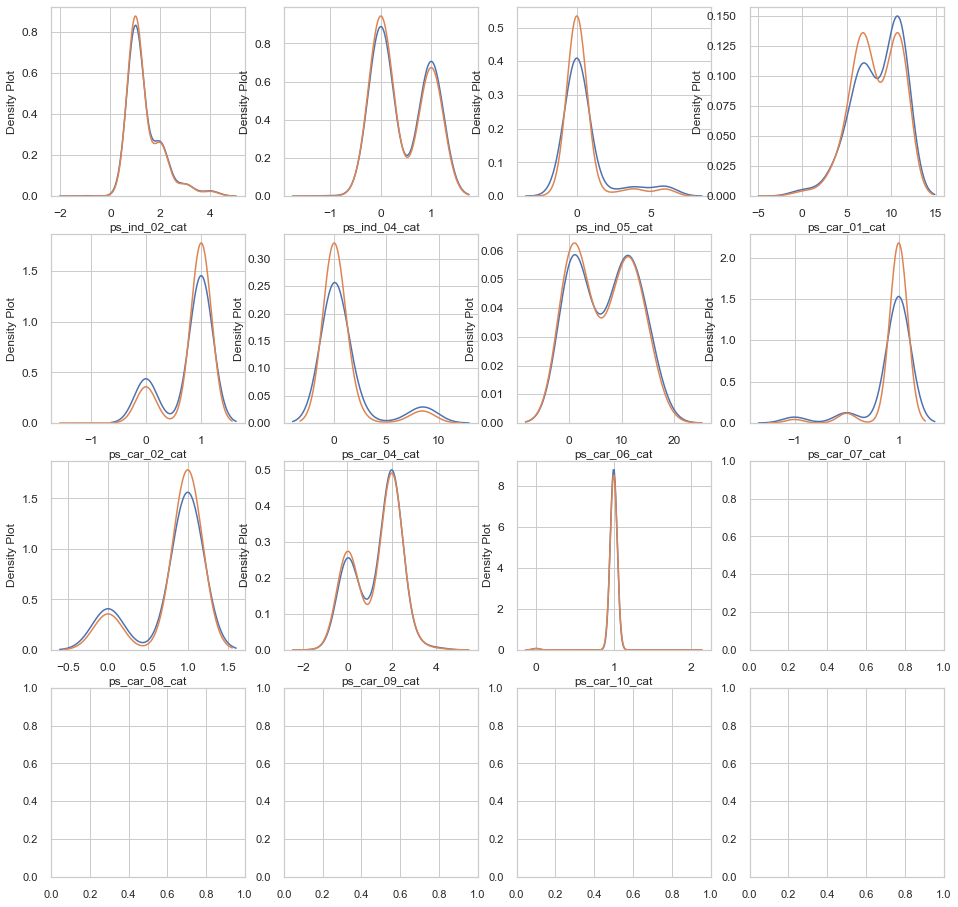

In [79]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

i = 0
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] != 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for feature in v:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density Plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### 7.2 Interval variables

### 7.2.1 Heatmap

A <b>heatmap</b> is a good way to visualize the correlation between interval variables

<b>method1</b>
- https://plotly.com/python/reference/layout/xaxis/
- ticks : Determines whether ticks are drawn or not (options : "", "inside", "outside")
- nticks : the maximum number of ticks for the particular axis

There are a huge number of columns that are not linearly correlated with each other at all. This is quite a useful observation to us, especially if we are trying to perform dimensionality reduction transformations such as <b>Principal Component Analysis (PCA)</b>, this would require a certain degree of correlation.

In [80]:
v = meta[(meta.level == 'interval') & (meta.keep)].index   

data = [
    go.Heatmap(
        z = train[v].corr().values,
        x = train[v].columns.values,  # columns' names
        y = train[v].columns.values,
        colorscale = 'Portland',      # option : Portland, Viridis
        reversescale = False,        # color option
        opacity = 1.0)                # opacity of colors
]

layout = go.Layout(
    title = 'Pearson correlation of features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks=''),
    width = 350, height = 350
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

<b>method2</b>

seaborn.diverging_palette
- https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
- as_cmapbool = True : return a matplotlib.colors.Colormap

heatmap
- https://seaborn.pydata.org/generated/seaborn.heatmap.html
- vmax : 최대값
- center : 중앙값
- annot_kws={"size": 12} : 그래프 안 글자 크기
- cbar_kws : 오른쪽 막대기 설정 ('shrink':.75 - 전체 그래프의 75% 길이)

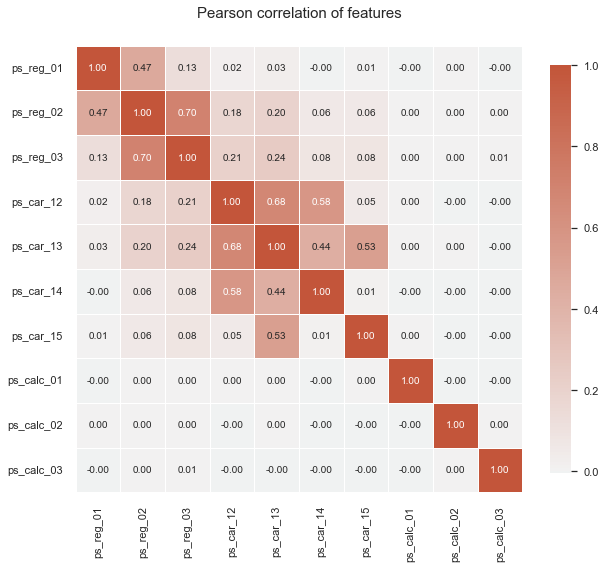

In [81]:
def corr_heatmap(v):
    corr = train[v].corr()
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    #cmap = colormap
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(corr, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True,
                linecolor='white', linewidths=.5,
                annot=True, annot_kws={"size": 10},
                cbar_kws={'shrink':.75})
    plt.title('Pearson correlation of features', y=1.05, size=15)
    plt.show()

v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)    

<b>Take a sample of the train data to speed up the process</b>

In [82]:
s = train.sample(frac=0.1)   # 10% of the dataset

We could perform Principal Component Analysis (PCA) on the variables to reduce the dimensions. But as the number of correlated variables is rather low, we will let the model do the heavy-lifting.

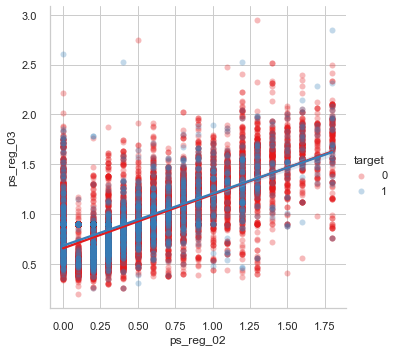

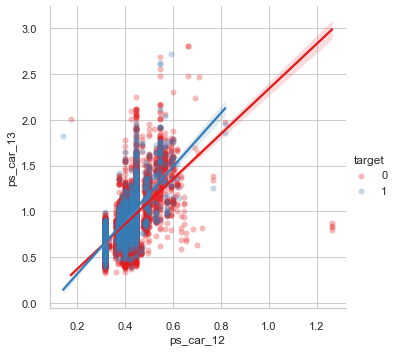

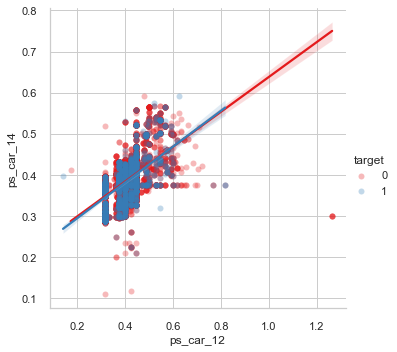

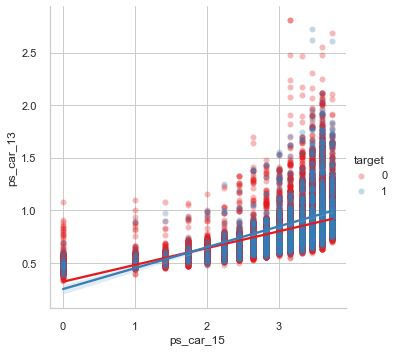

In [83]:
corr_lst = [['ps_reg_02','ps_reg_03'], ['ps_car_12','ps_car_13'], ['ps_car_12','ps_car_14'], ['ps_car_15','ps_car_13']]

for lst in corr_lst:
    sns.lmplot(x=lst[0], y=lst[1], data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3}, size=5)
    plt.show()

### 7.2.2 Density Plot

<b>Sample</b>
- Extract 5% from train set

In [84]:
sample = train.sample(frac=0.05)
print(train.shape, sample.shape)

(216940, 57) (10847, 57)


ps_car_12 are (with some approximations) square roots (divided by 10) of natural numbers whilst ps_car_15 are square roots of natural numbers. Let's represent the values using pairplot.

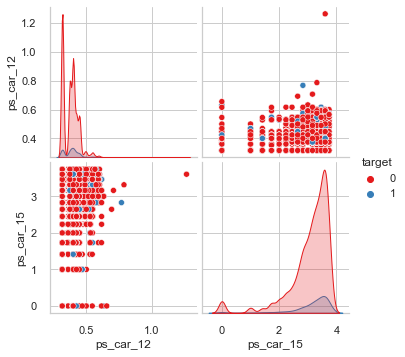

In [85]:
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

- The features ps_calc_01, ps_calc_02 and ps_calc_03 have very similar distributions and could be some kind of ratio, since the maximum value is for all three 0.9
- The other calculated values have maximum value an integer value (5,6,7,10,12)

<Figure size 432x288 with 0 Axes>

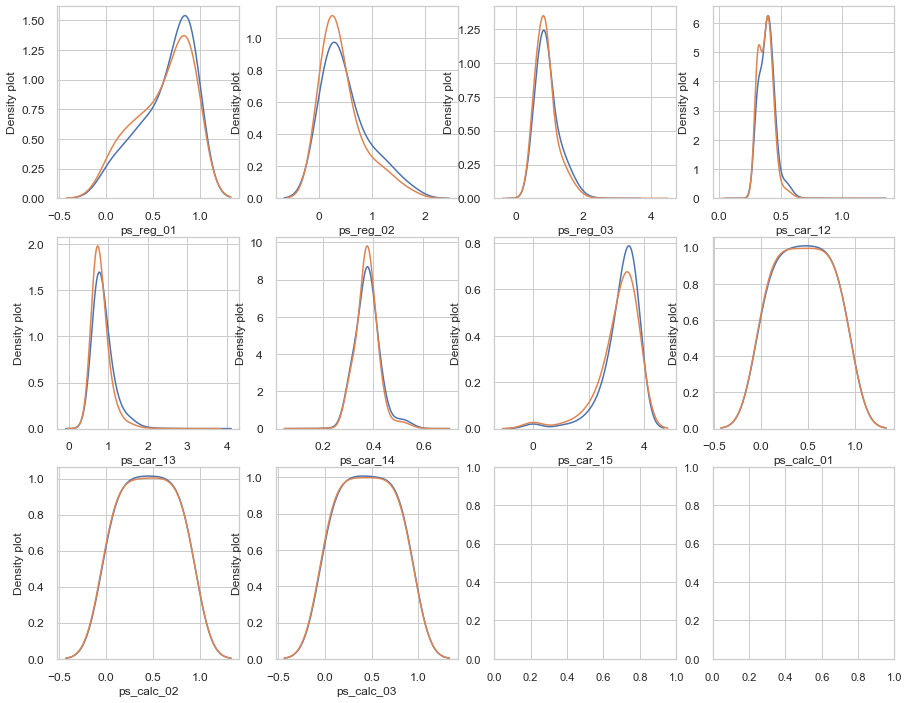

In [86]:
var = meta[(meta.level=='interval') & (meta.keep)].index

i = 0
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] != 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(15,12))

for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Let's visualize the plots of the variables with strong correlations

To show the pairs of values that are correlated we use pairplot. Before representing the pairs, we subsample the data, using only 5% in the sample.

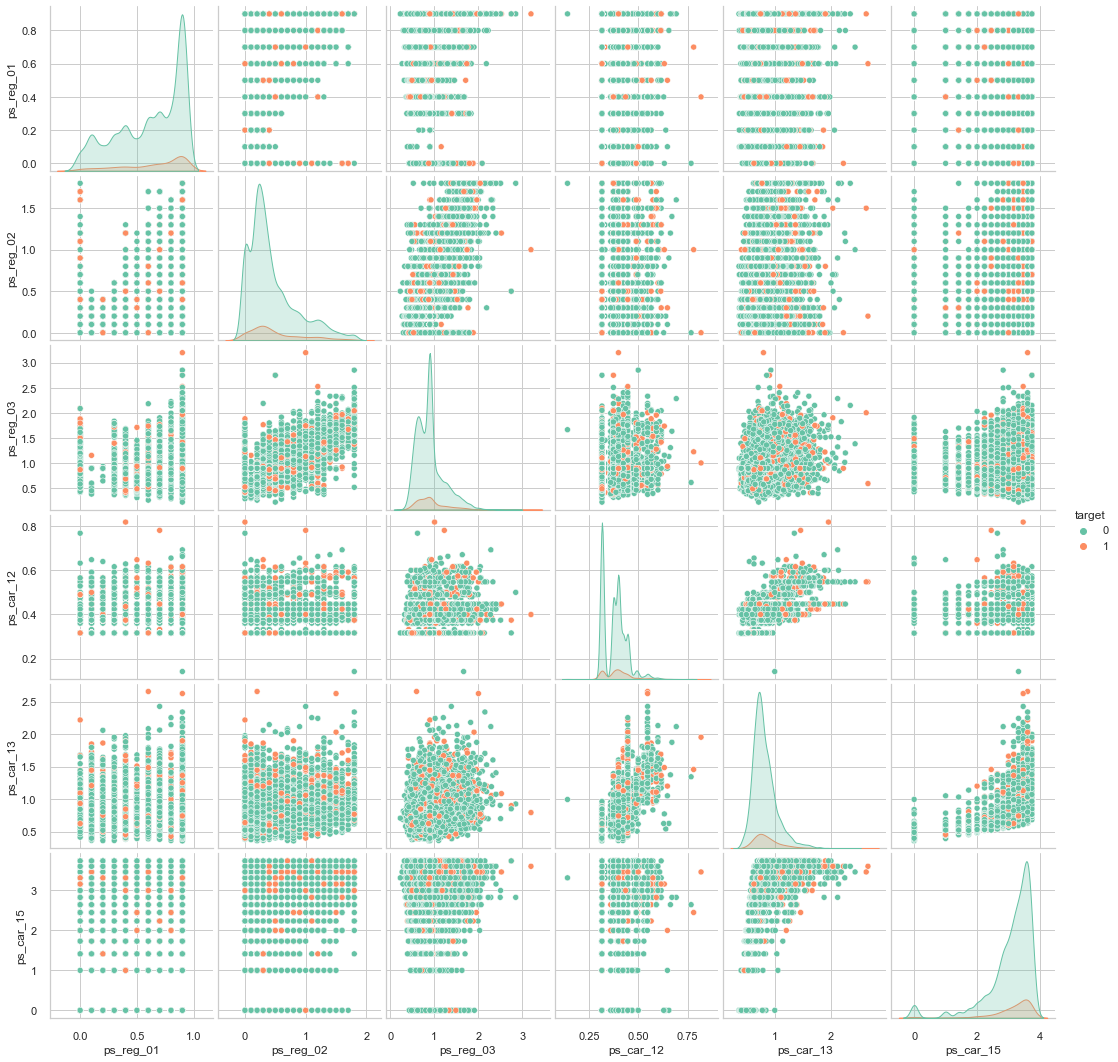

In [87]:
sample = train.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set2', diag_kind='kde')
plt.show()

### 7.3 Ordinal variables

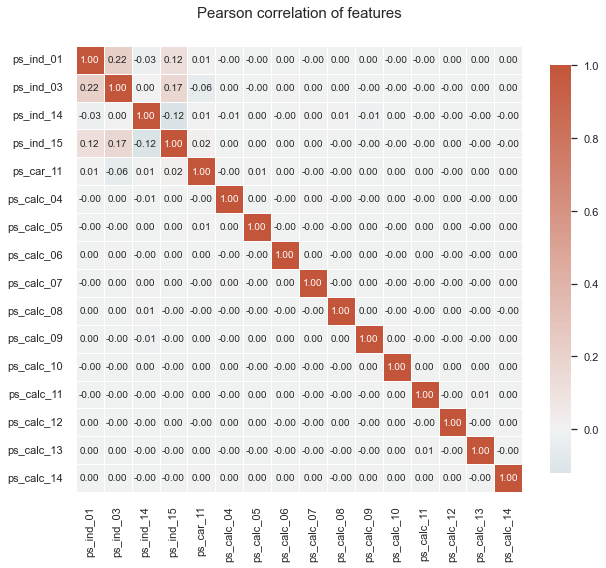

In [88]:
v = meta[(meta.level=='ordinal') & (meta.keep)].index
corr_heatmap(v)

### 7.4 Mutual Information plots

<b>Sklearn's mutual_info_classif method</b>
- for classification problems
- measures the <b>dependency between two random variables</b>
- zero : where the random variables are independent of each other
- higher values : indicate some dependency

This will give us an idea of how much information from the target may be contained within the features. It "relies on <b>nonparametric methods</b> based on entropy estimation from k-nearest neighbors distances", where you can go into more detail on the official sklearn page in the link here.

In [89]:
train_float = train.select_dtypes(include=['float64'])

mic = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=42)
print(mic)

[0.0054826  0.00314811 0.00308351 0.00445173 0.00425909 0.00312013
 0.00560449 0.001945   0.00268974 0.00257929 0.00211255]


### 7.5 Binary variables

### 7.5.1 Bar Plot

'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin' are completely <b>dominated by zeros</b>. This begs the question of <b>whether these features are useful</b> at all.

In [90]:
v = meta[(meta.level == 'binary') & (meta.keep)]

zero_lst = []
one_lst = []

for col in v.index:
    zero_lst.append((train[col] == 0).sum())
    one_lst.append((train[col] == 1).sum())

<b>method1</b>

In [91]:
trace1 = go.Bar(x = v.index, y = zero_lst, name = 'Zero count')
trace2 = go.Bar(x=v.index, y=one_lst, name='One count')

data = [trace1, trace2]

layout = go.Layout(barmode='stack', title='Count of 1 and 0 in binary variables', width=700, height=500)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

<b>method2</b>

In [92]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_lst, one_lst = [], []

for col in bin_col:
    zero_lst.append((train[col] == 0).sum() / train.shape[0] * 100)
    one_lst.append((train[col] == 1).sum() / train.shape[0] * 100)

<Figure size 432x288 with 0 Axes>

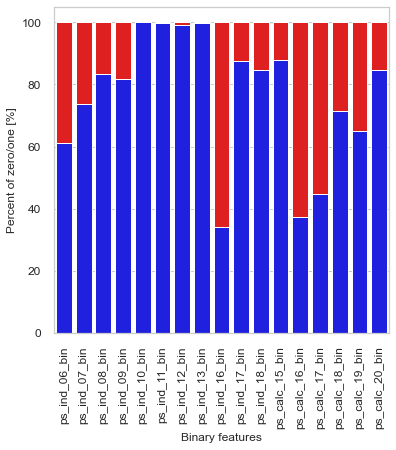

In [93]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_lst, color='blue')
p2 = sns.barplot(ax=ax, x=bin_col, y=one_lst, bottom=zero_lst, color='red')
plt.xlabel('Binary features', fontsize=12)
plt.ylabel('Percent of zero/one [%]', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show()

### 7.5.2 Distribution Plot

<Figure size 432x288 with 0 Axes>

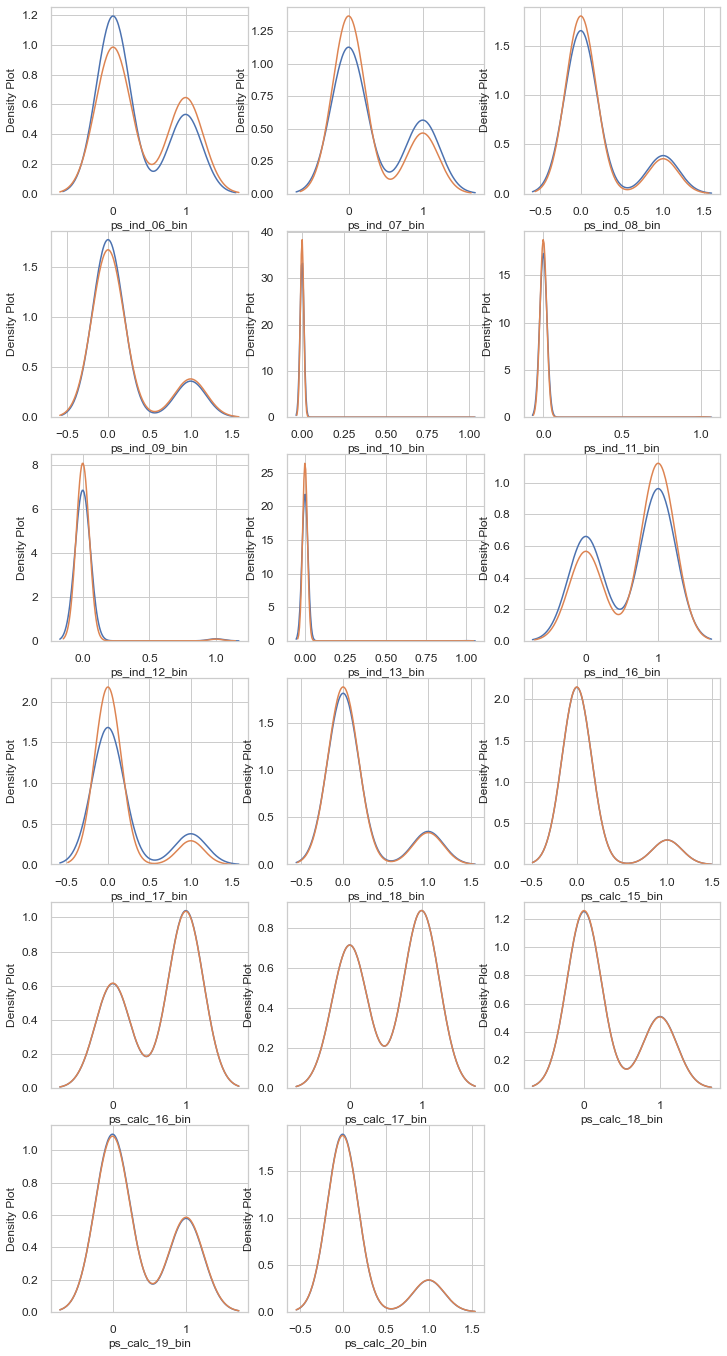

In [94]:
var = [col for col in train.columns if '_bin' in col]
i = 0
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] != 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 5, figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6, 3, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density Plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show();

### 7.6 Data unbalance between train and test data

In [95]:
def comparePlot(category, nrow, ncol, width, height):
    
    v = meta[(meta.category == category) & (meta.keep)].index
    
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow, ncol, figsize=(width, height))
    i = 0
    
    for feature in v:
        i += 1
        plt.subplot(nrow, ncol, i)
        sns.kdeplot(train[feature], bw=0.5, label='train')
        sns.kdeplot(test[feature], bw=0.5, label='test')
        plt.ylabel('Distribution', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

### 7.6.1 Registration

<Figure size 432x288 with 0 Axes>

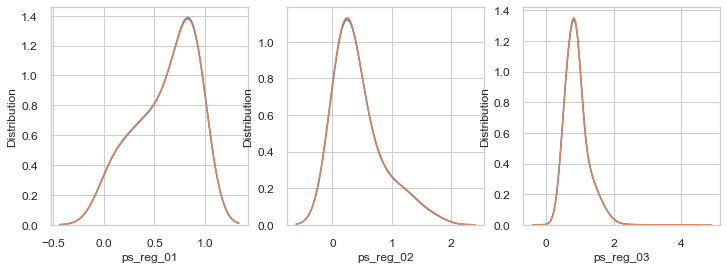

In [96]:
comparePlot('registration', 1, 3, 12, 4)

### 7.6.2 Car

<Figure size 432x288 with 0 Axes>

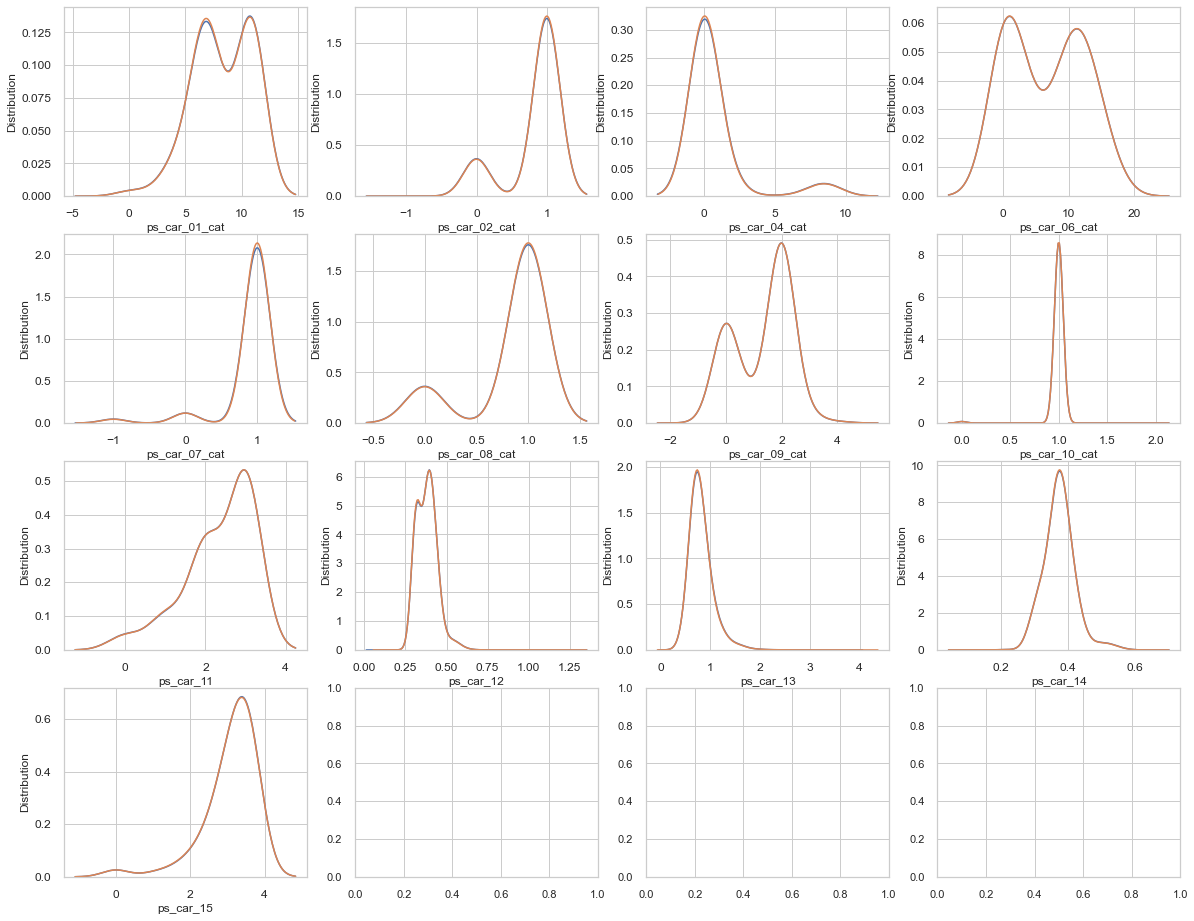

In [97]:
comparePlot('car', 4, 4, 20, 16)

### 7.6.3 Individual

<Figure size 432x288 with 0 Axes>

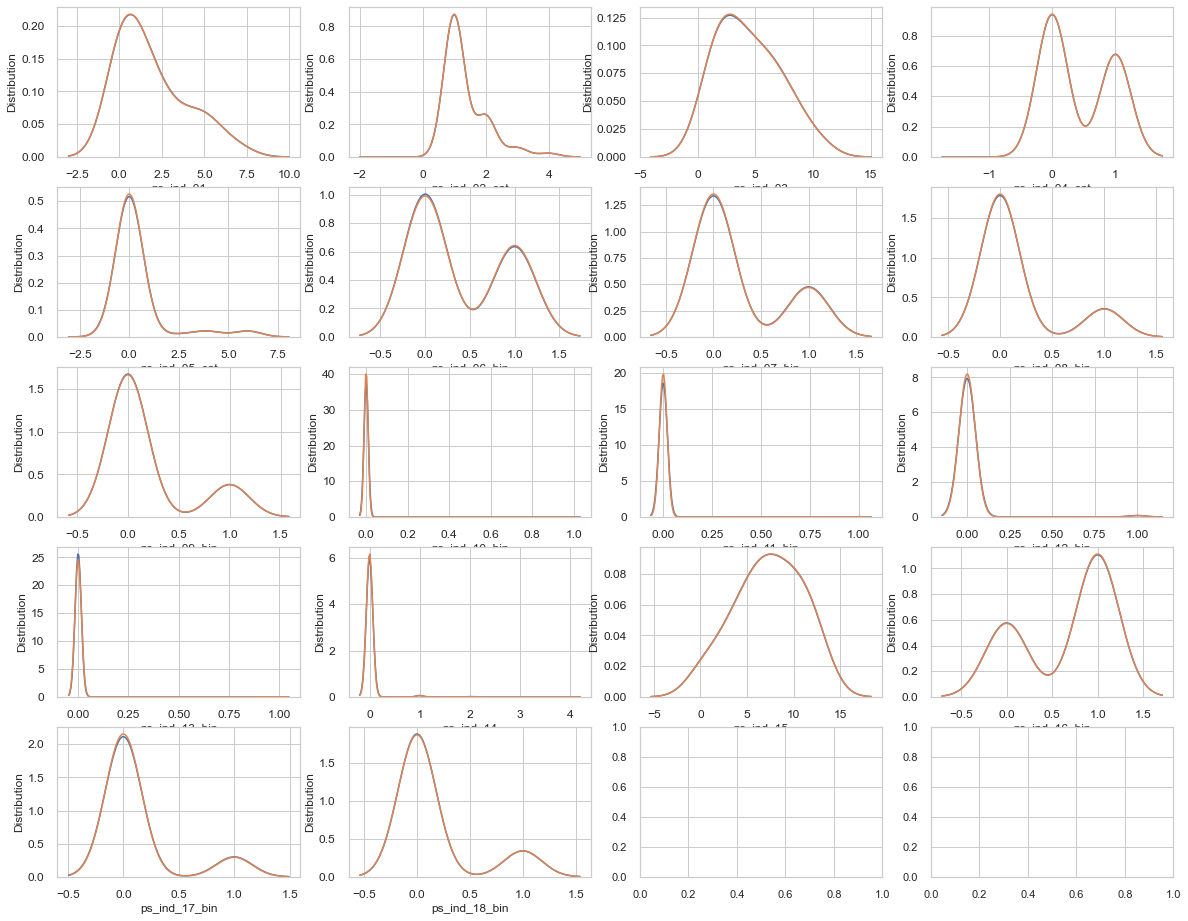

In [98]:
comparePlot('individual', 5, 4, 20, 16)

### 7.6.4 Calculated

<Figure size 432x288 with 0 Axes>

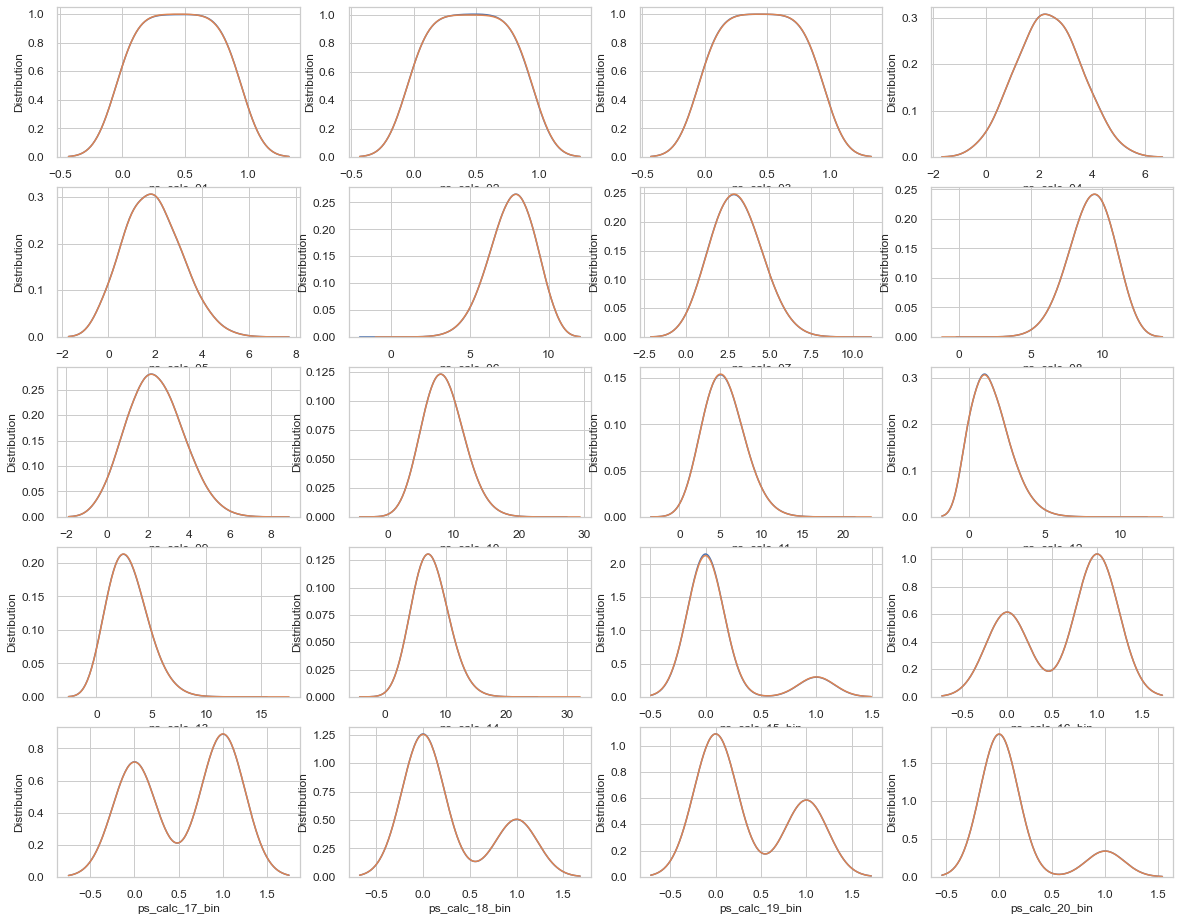

In [99]:
comparePlot('calculated', 5, 4, 20, 16)

# Part2: Feature Engineering and Data Cleaning

## 1. Create Dummy Variables

In [100]:
v = meta[(meta.level=='nominal') & (meta.keep)].index

print('Before dummification we have {} variables in train, {} variables in test'.format(train.shape[1], test.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
test = pd.get_dummies(test, columns=v, drop_first=True)

print('After dummification we have {} variables in train, {} variables in test'.format(train.shape[1], test.shape[1]))

Before dummification we have 57 variables in train, 56 variables in test
After dummification we have 109 variables in train, 108 variables in test


## 2. Create Interaction Variables

<b>PolynomialFeatures</b>
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
- degree : 차수 (다항식)
- interaction_only=True : interaction features are produced
- get_feature_names : assign column names to these new variables

In [101]:
v = meta[(meta.level=='interval') & (meta.keep)].index

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)

interactions_test = pd.DataFrame(data=poly.fit_transform(test[v]), columns=poly.get_feature_names(v))
interactions_test.drop(v, axis=1, inplace=True)

print('Before creating interaction we have {} variables in train, {} variables in test'.format(train.shape[1], test.shape[1]))
train = pd.concat([train, interactions], axis=1)
test = pd.concat([test, interactions_test], axis=1)
print('After creating interaction we have {} variables in train, {} variables in test'.format(train.shape[1], test.shape[1]))

Before creating interaction we have 109 variables in train, 108 variables in test
After creating interaction we have 164 variables in train, 163 variables in test


## 3. Feature Selection

Remove features with low or zero variance

<b>sklearn.VarianceThreshold</b>
- threshold : drop the feature if it has lower variance than the given percentage (default : features with zero variance)

<b>get_support([indices])</b>
- Get a mask, or integer index, of the features selected

In [102]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1))

f = np.vectorize(lambda x : not x)

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]

In [103]:
print(f(selector.get_support()))

print('\n{} variables have too low variance'.format(len(v)))
print('These variables are {}'.format(list(v)))

[False False False False False False  True  True  True  True False False
 False False False False False False False  True False  True False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False  True False False  True False  True  True  True
 False False False False False False False False False False False False
 False  True  True  True  True  True False False False  True False False
  True False False  True False False False  True False False False  True
  True False False False False False False False  True  True  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False  True False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False]

29 variables

## 4. Feature Scaling

In [104]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.64749816, -0.96267817, -0.52496987, ..., -0.72636977,
         0.33840411,  1.95902633],
       [-0.84331191, -0.96267817,  1.69137659, ...,  0.28196561,
         1.68508184,  1.95902633],
       [ 0.73793219,  2.0596649 ,  0.95259444, ..., -0.12883769,
        -1.00827361, -1.05963336],
       ...,
       [ 1.73345705, -0.96267817,  0.58320336, ..., -0.46494948,
         0.18877325,  0.28199317],
       [ 1.73353162, -0.96267817, -0.89436094, ..., -0.91309854,
        -0.40975018,  0.28199317],
       [ 1.73380659, -0.45895433, -1.26375202, ...,  0.28196561,
        -0.11048846, -0.72422673]])

# Part3: Predictive Modeling

In [107]:
print(train.shape, test.shape)

(216940, 164) (892816, 163)


In [106]:
X_tr = train.drop(['id', 'target'], axis=1)
y_tr = train['target']
feat_labels = X_tr.columns

## 1. Create Models

### 1.1 Random Forest

In [108]:
rf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=42, )
rf.fit(X_tr, y_tr)

RandomForestClassifier(max_depth=8, max_features=0.2, min_samples_leaf=4,
                       n_jobs=-1, random_state=42)

<b>SelectFromModel</b>
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
- threshold : use for feature selection (features whose importance is greater or equal are kept)
- prefit = True : transform must be called directly and SelectFromModel cannot be used with cross_val_score, GridSearchCV and similar utilities that clone the estimator
- prefit = False : train the model using fit and then transform to do feature selection

<b>get_support</b>
- With the get_support method we can then limit the number of variables in the train data

In [109]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print("Number of features before selection : {}".format(X_tr.shape[1]))
n_features = sfm.transform(X_tr).shape[1]
print("Number of features after selection : {}".format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection : 162
Number of features after selection : 81


In [110]:
train_rf = train[selected_vars + ['target']]

### 1.2 Ensemble

<b>StratifiedKFold</b>
- target에 속성값 개수를 동일하게 하여, kfold처럼 데이터가 한 곳으로 몰리는 것 방지

<b>Ensemble class for cross validation and ensamble</b>
Prepare an Ensamble class to split the data in KFolds, train the models and ensamble the results

The class has an <b>init</b> method (called when an Ensamble object is created) that accepts 4 parameters:
- self - the object to be initialized
- n_splits - the number of cross-validation splits to be used
- stacker - the model used for stacking the prediction results from the trained base models
- base_models - the list of base models used in training

A second method, <b>fit_predict</b> has four functions:
- split the training data in n_splits folds
- run the base models for each fold
- perform prediction using each model
- ensamble the resuls using the stacker

In [111]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models
    
    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        
        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42).split(X, y))
        
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            
            S_test_i = np.zeros((T.shape[0], self.n_splits))
            
            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                print("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                
                y_pred = clf.predict_proba(X_holdout)[:,1]
                
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            
            S_test[:, i] = S_test_i.mean(axis=1)
        
        rst = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        print("Stacker score [gini]: %.5f" % (2 * rst.mean() - 1))
        
        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:, 1]
        return res

<b>Parameters for the base models</b>
- For the base models, we prepare three different LightGBM models and one XGB model
- Each model is used to train the data (using as well cross-validation, with 3 folds)

In [112]:
lgb_params1 = {
    'learning_rate' : 0.02,
    'n_estimators' : 650,
    'max_bin' : 10,
    'subsample' : 0.8,
    'subsample_freq' : 10,
    'colsample_bytree' : 0.8,
    'min_child_samples' : 500,
    'seed' : 314,
    'num_threads' : 4
}

lgb_params2 = {
    'learning_rate' : 0.02,
    'n_estimators' : 1090,
    'subsample' : 0.7,
    'subsample_freq' : 2,
    'colsample_bytree' : 0.3,
    'seed' : 314,
    'num_threads' : 4,
    'num_leaves' : 16
}

lgb_params3 = {
    'learning_rate' : 0.02,
    'n_estimators' : 1100,
    'max_depth' : 4,
    'seed' : 314,
    'num_threads' : 4
}

xgb_params = {
    'learning_rate' : 0.04,
    'n_estimators' : 490,
    'objective' : 'binary:logistic',
    'max_depth' : 4,
    'subsample' : 0.9,
    'colsample_bytree' : 0.9,
    'min_child_weight' : 10,
    'num_threads' : 4
}

<b>Initialize the models with the parameters</b>
- We init the 3 base models and the stacking model
- For the base models we are using the predefined parameters initialized above.

In [113]:
lgb_model1 = LGBMClassifier(**lgb_params1)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)
xgb_model = XGBClassifier(**xgb_params)

Stacking model
- Using Ensamble.init we init the stacking object

In [114]:
log_model = LogisticRegression()

stack = Ensemble(n_splits=3,
                stacker=log_model,
                base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))

<b>Run the predictive models</b>

In [115]:
print("Check the number of variables : ", train.shape, test.shape)

Check the number of variables :  (216940, 164) (892816, 163)


In [ ]:
X_stack_tr = train.drop(['id', 'target'], axis=1)
y_stack_tr = train['target'].values
X_stack_te = test.drop(['id'], axis=1)

y_prediction = stack.fit_predict(X_stack_tr, y_stack_tr, X_stack_te)

Base model 1: fit LGBMClassifier model | fold 1
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc-auc]: 0.63583 [gini]: 0.27165
Base model 1: fit LGBMClassifier model | fold 2
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc-auc]: 0.63651 [gini]: 0.27302
Base model 1: fit LGBMClassifier model | fold 3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored.

## 2. Decision Tree Visualization

In [ ]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

- out_file : name of the output file (default : tree.dot)

In [ ]:
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(X_tr, y_tr)

with open('tree_viz.dot', 'w') as f:
    f = tree.export_graphviz(decision_tree, out_file=f, max_depth=4, impurity=False, feature_names=X_tr.columns.values,
                            class_names=['No', 'Yes'], rounded=True, filled=True)

<b>Convert .dot to .pnt to allow display in web notebook</b>

check_call
- call()과 달리 서브 프로세스에 의한 처리가 성공하는 것이 보장되어야 하는 경우 사용
- 서브 프로세스의 명령이 비정상 종료하였다면 리턴코드는 0이 아니고, CalledProcessError 발생

In [ ]:
check_call(['dot', '-Tpng', 'tree_viz.dot', '-o', 'tree_viz.png'], shell=True)

<b>Annotate chart with Python Imaging Library(PIL)</b>

- 이미지 객체 선언 : PImage 객체명
- 객체에 이미지 파일 저장 : 객체명 = loadImage("파일명.확장자")
- 화면에 이미지 나타내기 : image(객체명, x, y, 너비, 높이)

In [ ]:
img = Image.open('tree_viz.png')
draw = ImageDraw.Draw(img)

# 다른 이름으로 저장
img.save('sample-out.png')
PImage('sample-out.png')

## 3. Feature importance

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_tr.shape[1]):
    print('%2d) %-*s %f' % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

### 3.1 Plot.ly Scatter Plot of feature importances

In [ ]:
trace = go.Scatter(
    x = X_tr.columns.values,
    y = rf.feature_importances_,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        # size = rf.feature_importances_,
        color = rf.feature_importances_,
        # color = np.random.randn(500),
        colorscale = 'Portland',
        showscale = True
    ),
    text = features
)

data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    xaxis = dict(ticklen=5, showgrid=False, zeroline=False, showline=False),
    yaxis = dict(title='Feature Importance', ticklen=5, showgrid=False, zeroline=False, gridwidth=2),
    showlegend = False,
    width = 800,
    height = 600
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

### 3.2 Sorted list of all the features ranked by order of their importance

- zip(*zip_list) : unzip, unpack

In [ ]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse=False)))

trace = go.Bar(
    x=x, y=y,
    marker=dict(color=x, colorscale='Viridis', reversescale=True),
    name='Random Forest Feature Importance',
    orientation='h'
)

layout = dict(
    title='Barplot of Feature Importances',
    width=500, height=900,
    yaxis=dict(showgrid=False, showline=False, showticklabels=True)
)

fig = go.Figure(data=[trace])
fig['layout'].update(layout)
py.iplot(fig, filename='plots')

## 4. Submission

In [ ]:
sub = pd.Dataframe()
sub['id'] = test['id']
sub['target'] = y_prediction
sub.to_csv('stacked.csv', index=False)